CocaCola sales seem to follow a cycle of four quarters (using quarterly data). We model the sales below.

In the linear model of seasonality:

![image.png](attachment:image.png)

the coefficients of the dummy variables b1, b2 and b3 indicate how much each quarter differs from the reference quarter, quarter4.
The average increase from one quarter to the next is b (the coefficient of t). This is the trend effect.  Quarter 1 averages b1 units higher than the reference quarter, quarter 4, quarter 2 averages b2 units higher than quarter 4, etc. These other coefficients indicate the effect of seasonality.


In what follows we are implementing a multiplicative seasonal model of seasonality:


![image.png](attachment:image.png)

Which after taking logs is:

![image.png](attachment:image.png)

In this multiplicative model the coefficients are percentage changes in the original sales variable Y.  The coefficient of time means that deseasonalized sales increase by b% per quarter. This is the trend effect. The coefficients b1, b2 and b3 mean that the sales in quarters 1, 2 and 3 are respectively b1% above quarter 4, b2% above quarter 4 and b3% above quarter 4. Quarter 4 is the reference quarter.

In [122]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
#The following function is borrowed from :  Dmitriy Sergeyev, Data Scientist @ Zeptolab, lecturer in the Center of Mathematical Finance in MSU
#https://mlcourse.ai/articles/topic9-part1-time-series/

import statsmodels.api as sm
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries pandas series
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Agumented Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [124]:
def detrendPrice(dft):
    #make sure the input dft has no Nan, otherwise OLS will break
    # fit linear model
    series=dft.Sales
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    results = model.fit()
    predictions = results.predict(x_const)
    resid = y - predictions
    df=pd.DataFrame(resid, columns=['Sales'])
    df.index = dft.index
    return df

In [125]:
def MAD_mean_ratio(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.mean(y_true))) * 100

In [126]:
#The following 2 functions are borrowed from :  Dmitriy Sergeyev, Data Scientist @ Zeptolab, lecturer in the Center of Mathematical Finance in MSU
#https://mlcourse.ai/articles/topic9-part1-time-series/

def plotModelResults(model, X_train, X_test, y_test, plot_intervals=False, test_data=True):
    """
        Plots modelled vs fact values, prediction intervals

    """
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                                    cv=tscv,
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

    error = MAD_mean_ratio(prediction, y_test)
    if (test_data==True):
        plt.title("Test data MAD_mean_ratio error {0:.2f}%".format(error))
    else:
        plt.title("Train data MAD_mean_ratio error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

def plotCoefficients(model,X_train):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [127]:
# Read the data into a pandas dataframe
df = pd.read_csv('CocaCola.csv', parse_dates=['Date'], infer_datetime_format=True)

df['datetime'] = pd.to_datetime(df['Date'])
df.set_index('datetime', inplace=True)
df.drop(['Date'], axis=1, inplace=True)

df.head()

<ipython-input-127-532fe9b0fcfc>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('CocaCola.csv', parse_dates=['Date'], infer_datetime_format=True)


,Sales
datetime,
1986-04-01,1734.83
1986-07-01,2244.96
1986-10-01,2533.80
1987-01-01,2154.96
1987-04-01,1547.82


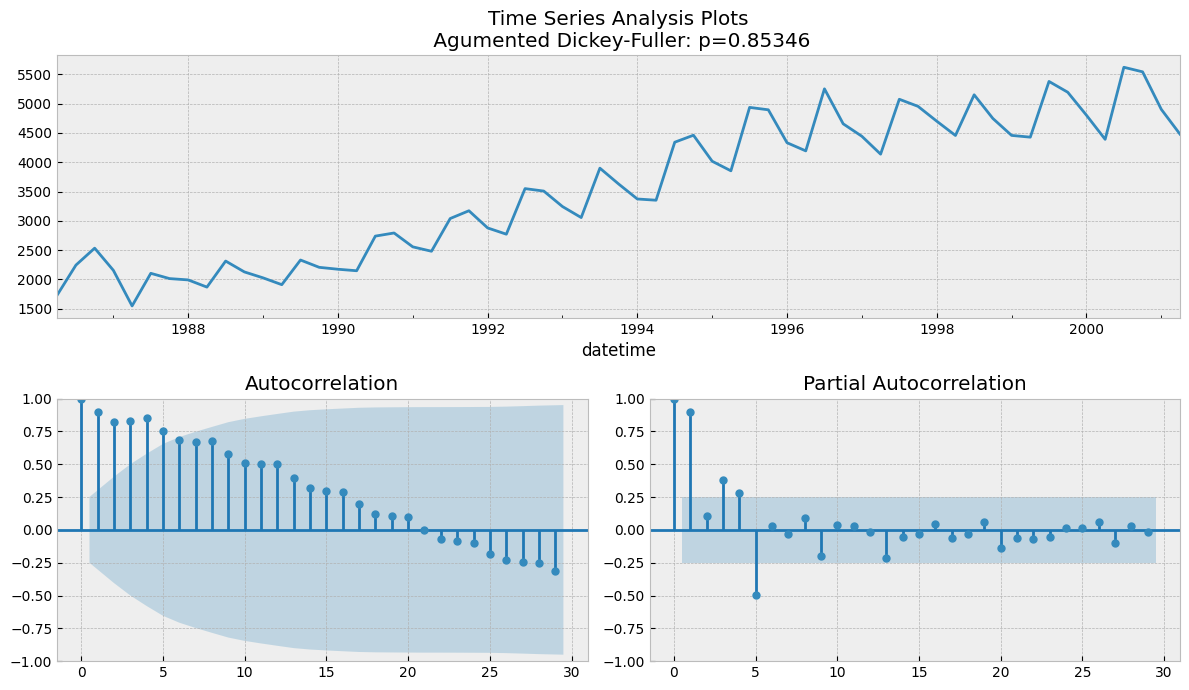

In [128]:
tsplot(df.Sales, lags=29)

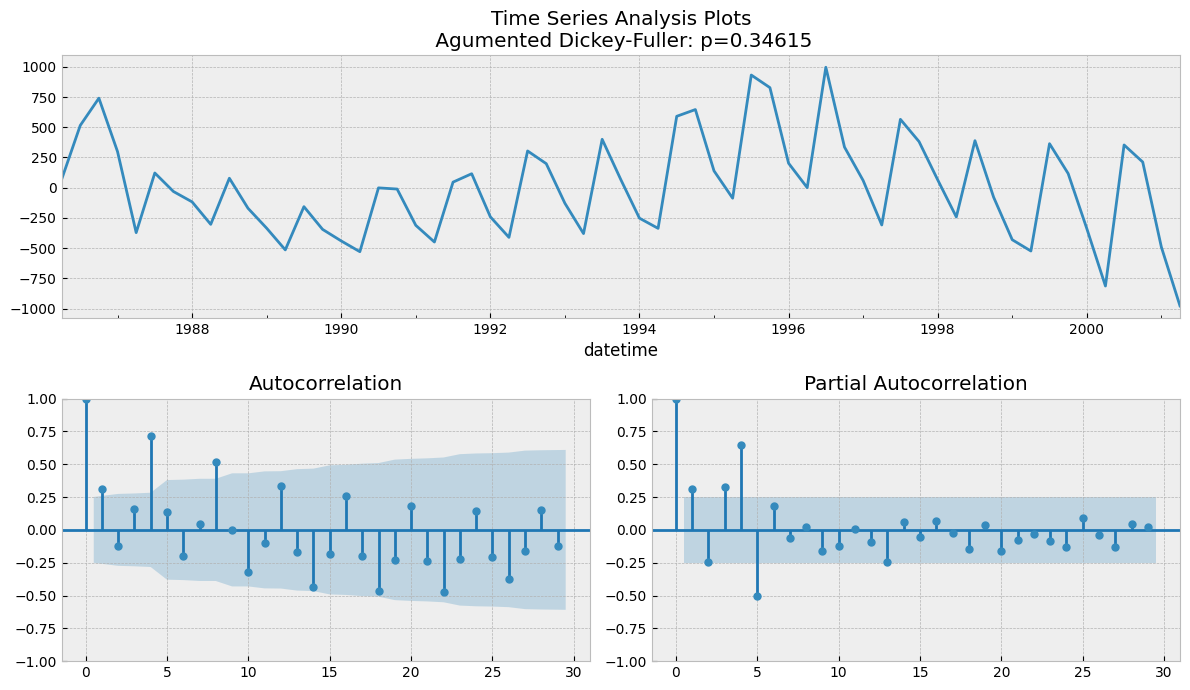

In [129]:
df.dropna(inplace=True)
df_detrended = detrendPrice(df)

tsplot(df_detrended.Sales, lags=29)

In [130]:
df["Sales"] = np.log(df["Sales"])
df["quarter"] = df.index.quarter

df.head()

,Sales,quarter
datetime,,
1986-04-01,7.458665,2
1986-07-01,7.716443,3
1986-10-01,7.837475,4
1987-01-01,7.675527,1
1987-04-01,7.344603,2


In [131]:
df_dummies = pd.get_dummies(df["quarter"], prefix="quarter").astype(int)

df_dummies.head()

,quarter_1,quarter_2,quarter_3,quarter_4
datetime,,,,
1986-04-01,0,1,0,0
1986-07-01,0,0,1,0
1986-10-01,0,0,0,1
1987-01-01,1,0,0,0
1987-04-01,0,1,0,0


In [132]:
df = df.join(df_dummies)

df.head()

,Sales,quarter,quarter_1,quarter_2,quarter_3,quarter_4
datetime,,,,,,
1986-04-01,7.458665,2,0,1,0,0
1986-07-01,7.716443,3,0,0,1,0
1986-10-01,7.837475,4,0,0,0,1
1987-01-01,7.675527,1,1,0,0,0
1987-04-01,7.344603,2,0,1,0,0


In [133]:
df.drop(["quarter", "quarter_4"], axis=1, inplace=True)

df.head()

,Sales,quarter_1,quarter_2,quarter_3
datetime,,,,
1986-04-01,7.458665,0,1,0
1986-07-01,7.716443,0,0,1
1986-10-01,7.837475,0,0,0
1987-01-01,7.675527,1,0,0
1987-04-01,7.344603,0,1,0


In [134]:
list = []
list = range(0, df.shape[0])
df["time"] = list

df.head()

,Sales,quarter_1,quarter_2,quarter_3,time
datetime,,,,,
1986-04-01,7.458665,0,1,0,0
1986-07-01,7.716443,0,0,1,1
1986-10-01,7.837475,0,0,0,2
1987-01-01,7.675527,1,0,0,3
1987-04-01,7.344603,0,1,0,4


In [135]:
y = df["Sales"]
df.drop(["Sales"], axis=1, inplace=True)
X = df

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

lr = LinearRegression()
lr_fitted = lr.fit(X_train, y_train)

predictions_train = lr_fitted.predict(X_train)
predictions_test = lr_fitted.predict(X_test)

In [137]:
print("Train data MAD_mean_ratio error {}%".format(MAD_mean_ratio(predictions_train, y_train)))
print("Test data MAD_mean_ratio error {}%".format(MAD_mean_ratio(predictions_test, y_test)))

Train data MAD_mean_ratio error 0.751375633467679%
Test data MAD_mean_ratio error 2.4511803633878575%


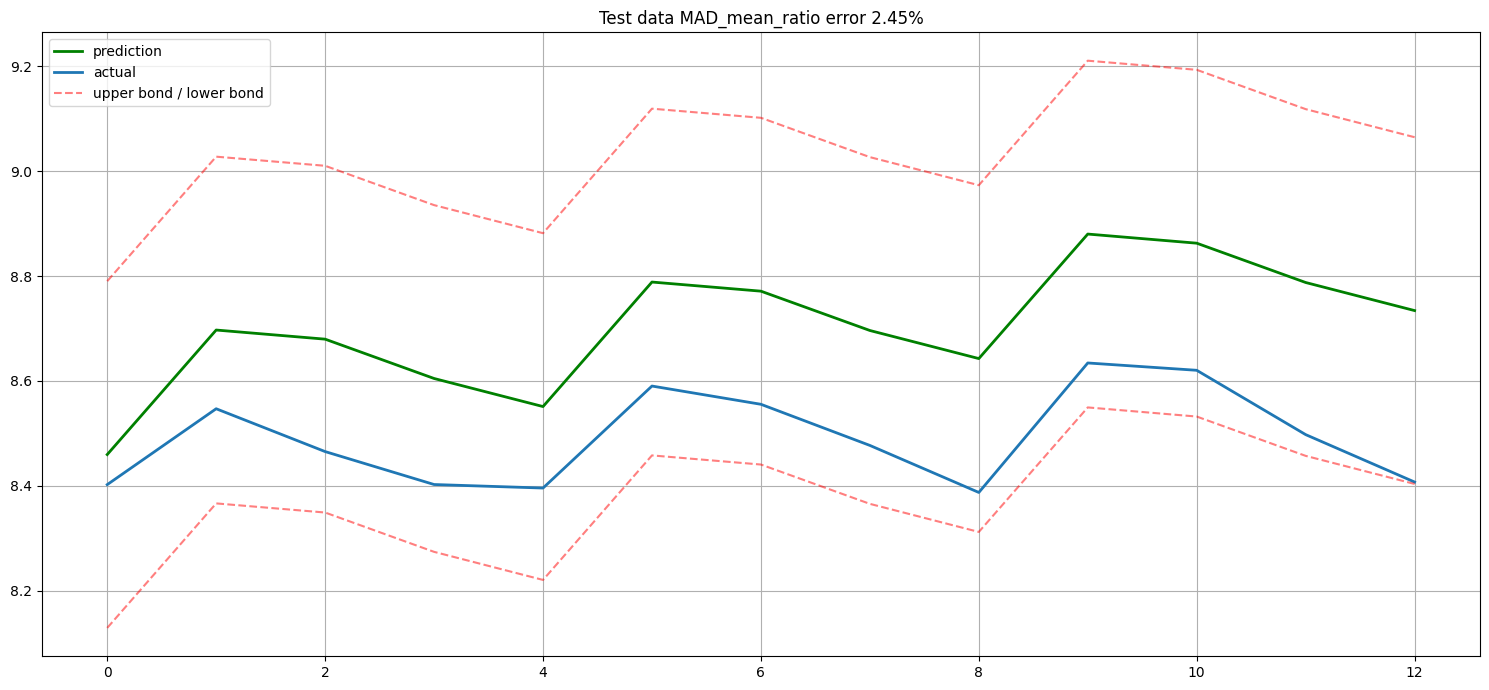

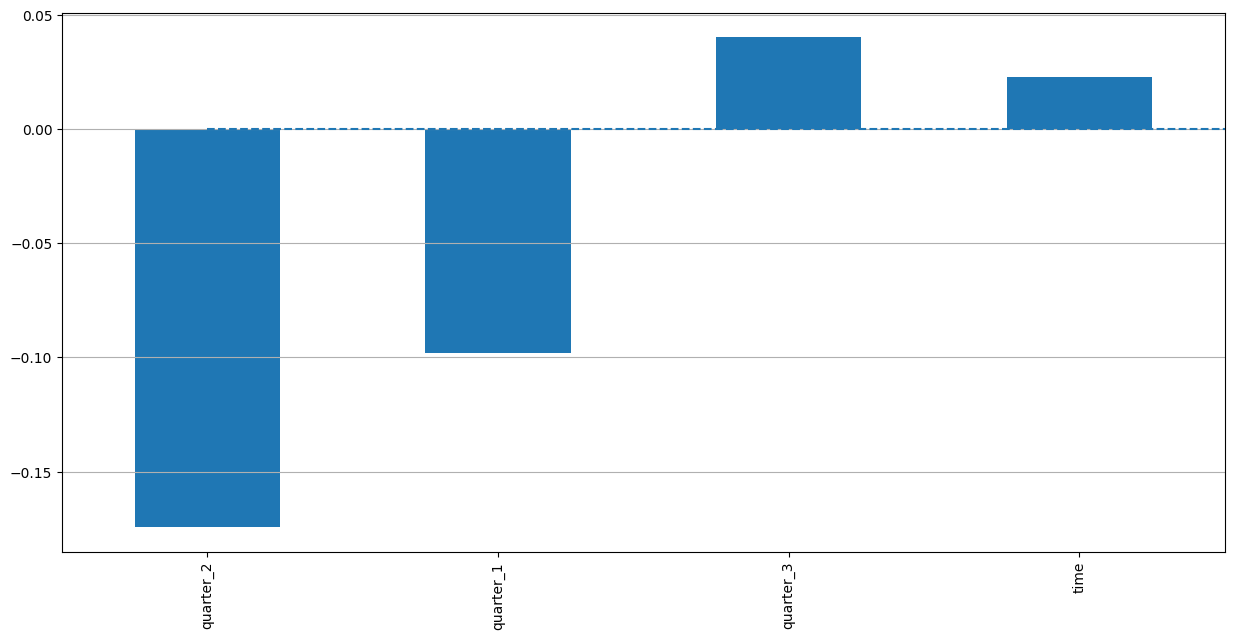

In [138]:
plotModelResults(lr_fitted, X_train, X_test, y_test, plot_intervals=True)
plotCoefficients(lr_fitted, X_train)

In [139]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])
tscv = TimeSeriesSplit(n_splits=5)

In [140]:
param_grid = {
    'ridge__alpha': np.logspace(-4, 4, 150)
}

grid_search = GridSearchCV(pipe, param_grid, cv=tscv, scoring="neg_mean_absolute_error")

In [141]:
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_params['ridge__alpha']))
])

best_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=5.306793820656121))])

In [142]:
predictions_train = best_model.predict(X_train)
predictions_test = best_model.predict(X_test)
print("Train data MAD_mean_ratio error {}%".format(MAD_mean_ratio(predictions_train, y_train)))
print("Test data MAD_mean_ratio error {}%".format(MAD_mean_ratio(predictions_test, y_test)))

Train data MAD_mean_ratio error 0.8332941645457157%
Test data MAD_mean_ratio error 1.6757722758318359%


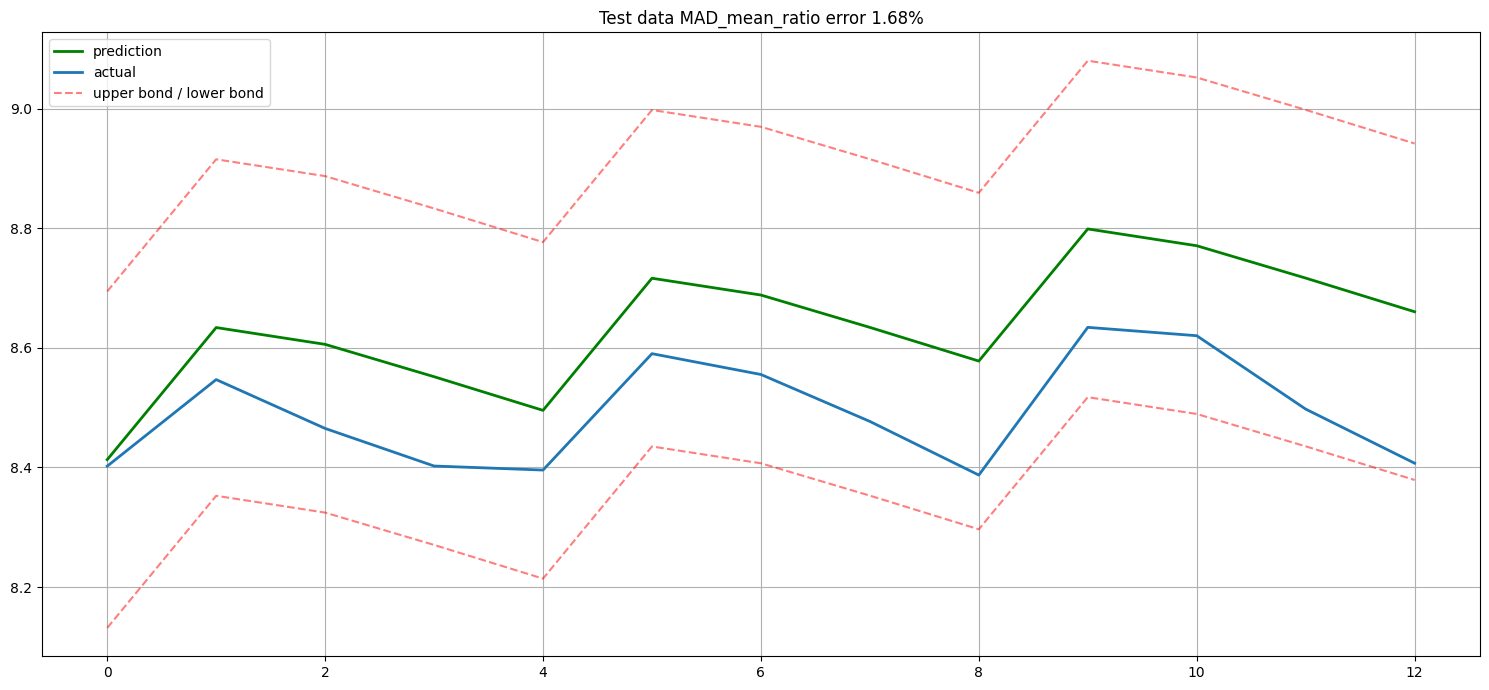

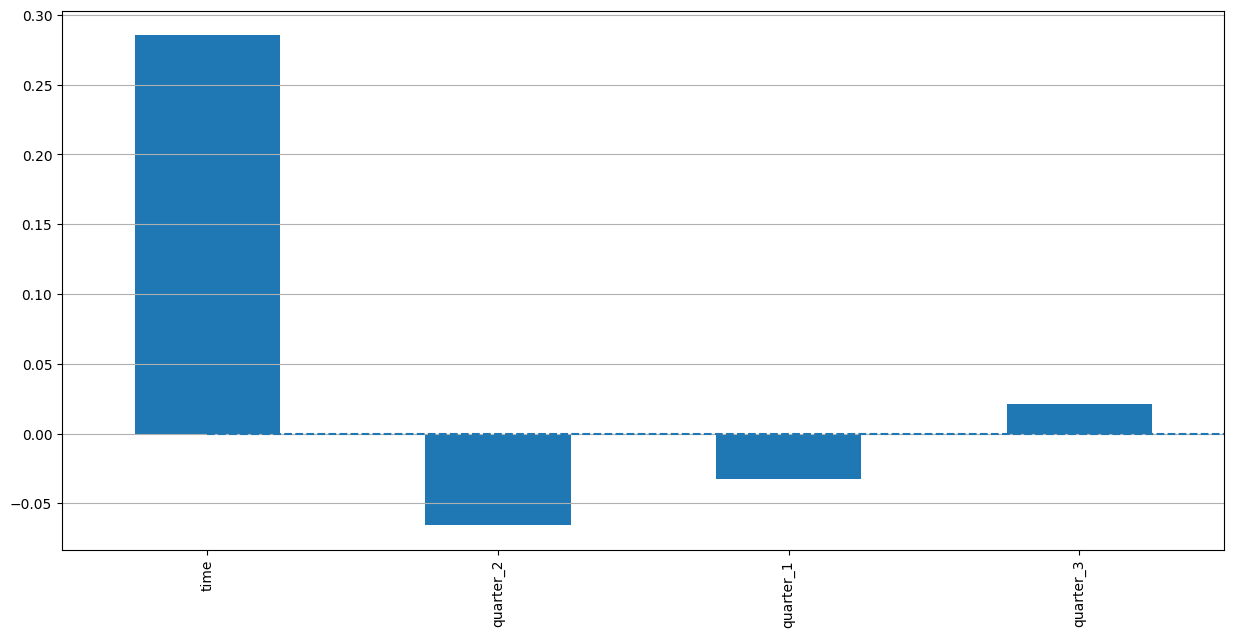

In [143]:
# Access the Ridge regression model within the pipeline
ridge_model = best_model.named_steps['ridge']

# Now you can access the coef_ attribute
coefs = pd.DataFrame(ridge_model.coef_, X_train.columns)
coefs.columns = ["coef"]
coefs["abs"] = coefs.coef.apply(np.abs)

plotModelResults(best_model, X_train, X_test, y_test, plot_intervals=True)
plotCoefficients(ridge_model, X_train)

In [144]:
#This function  calculates the smallest value of lambda that
#forces coefficients to go down to zero in a model (ridge, lasso, or logistic)
#This smallest value of lambda is called LambdaMax.

#This function is following the equations in:
#https://archive.is/RVysJ#selection-803.0-803.6
#https://archive.is/vhQbn
#and in glmnet.pdf here: https://jerryfriedman.su.domains/ftp/glmnet.pdf

#X should be scaled

def LambdaMax(X, Y, model_type):
    from sklearn.linear_model import Ridge
    from sklearn.linear_model import Lasso
    from sklearn.linear_model import LogisticRegression

    if not isinstance(Y, np.ndarray):
         Y = Y.values #for logistic Y values should be categorical
    if not isinstance(X, np.ndarray):
        X = X.values #X values should be scaled

    n = X.shape[0]

    if model_type=="lasso":
        # Calculate LambdaMax for lasso-like regularization
        LambdaMax_lasso = np.max(np.abs(X.T @ Y))

        print("LambdaMax (for Lasso):", LambdaMax_lasso)
        model = Lasso(alpha=LambdaMax_lasso)
        model.fit(X,Y)
        print("lasso coefs", model.coef_ )#coefs should be close to zero

    if model_type == "ridge":
        # Calculate LambdaMax for ridge-like regularization
        LambdaMax_ridge = 2 * np.max(np.abs(X.T @ Y)) / n

        print("LambdaMax (for Ridge):", LambdaMax_ridge)
        model = Ridge(alpha=LambdaMax_ridge)
        model.fit(X,Y)
        print("ridge coefs", model.coef_ )#coefs should be close to zero

    if model_type == "logistic":
        # Fit logistic regression model without regularization (high C value means less regularization)
        model = LogisticRegression(penalty='l2', C=1e10, solver='liblinear')
        model.fit(X, Y)

        # Calculate the gradient of the loss function at the fitted coefficients
        # Logistic loss gradient w.r.t. coefficients: X.T * (Y - p)
        p = model.predict_proba(X)[:, 1]  # model predictions as probabilities
        gradients = np.dot(X.T, (Y - p))  # gradients of the loss function

        # Calculate LambdaMax_logistic for L2 Logistic Regression
        LambdaMax_logistic = np.max(np.abs(gradients))

        print("LambdaMax (for Logistic):", LambdaMax_logistic)
        print("C (for Logistic):", 1/LambdaMax_logistic)
        model =  LogisticRegression(C=1/LambdaMax_logistic) #C = 1/LambdaMax_logistic
        model.fit(X,Y)
        print("logistic coefs",model.coef_ )#coefs should be close to zero

In [145]:
LambdaMax(X_train, y_train, "ridge")

LambdaMax (for Ridge): 385.5511942335475
ridge coefs [-0.0011816  -0.00356179  0.00294035  0.02207759]


In [146]:
# Start value
start = 385.5511942335475
# End value
stop = 0.1
# Number of points
num_points = 50

In [147]:
evenly_spaced_values = np.linspace(start, stop, num_points)
param_grid = [{'ridge__alpha':evenly_spaced_values}]

In [148]:
grid_search = GridSearchCV(pipe, param_grid, cv=tscv, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid=[{'ridge__alpha': array([3.85551194e+02, 3.77684843e+02, 3.69818492e+02, 3.61952142e+02,
       3.54085791e+02, 3.46219440e+02, 3.38353089e+02, 3.30486738e+02,
       3.22620387e+02, 3.14754036e+02, 3.0688...
       1.65293369e+02, 1.57427018e+02, 1.49560667e+02, 1.41694316e+02,
       1.33827965e+02, 1.25961614e+02, 1.18095264e+02, 1.10228913e+02,
       1.02362562e+02, 9.44962108e+01, 8.66298599e+01, 7.87635090e+01,
       7.08971581e+01, 6.30308072e+01, 5.51644563e+01, 4.72981054e+01,
       3.94317545e+01, 3.15654036e+01, 2.36990527e+01, 1.58327018e+01,
       7.96635090e+00, 1.00000000e-01])}],
             scoring='neg_mean_absolute_error')

In [150]:
best_params = grid_search.best_params_
best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_params['ridge__alpha']))
])

best_model.fit(X_train, y_train)

predictions_train = best_model.predict(X_train)
predictions_test = best_model.predict(X_test)
print("Train data MAD_mean_ratio error {}%".format(MAD_mean_ratio(predictions_train, y_train)))
print("Test data MAD_mean_ratio error {}%".format(MAD_mean_ratio(predictions_test, y_test)))

Train data MAD_mean_ratio error 0.9079449029216908%
Test data MAD_mean_ratio error 1.3550788641012048%
